# Assignment 3, Question 2

<b>Group [fill in group number]</b>
* <b> Student 1 </b> : FILL IN STUDENT NAME + STUDENT NUMBER
* <b> Student 2 </b> : FILL IN STUDENT NAME + STUDENT NUMBER

**Reading material**
* [1] *Oriol Vinyals, Alexander Toshev, Samy Bengio, Dumitru Erhan, "Show and Tell: A Neural Image Caption Generator"*, CVPR, 2015. https://arxiv.org/abs/1411.4555

**Task:**
Implement and test the image caption generator proposed in [1], see further instructions below. 
Please insert your code between two consecutive occurrences of # ...

<b><font color='red'>NOTE</font></b> When submitting your notebook, please make sure that the training history of your model is visible in the output. This means that you should **NOT** clean your output cells of the notebook. Make sure that your notebook runs without errors in linear order.

In [0]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import pickle
import time
import nltk

import keras.backend as K
from tensorflow.keras import Model
from tensorflow.keras.models import load_model 
from tensorflow.keras.layers import Input, Embedding, Dense, LSTM, Dropout, concatenate
from tensorflow.keras import losses, optimizers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import drive

# training parameters
embedding_dim = 512
lstm_dim = 500
lstm_dropout = 0.5
batch_size = 100

Using TensorFlow backend.


# Mount Google Drive
We will save the data and our model there, in the folder deeplearning2020_ass3_task1.
**This requires about 600 MB**.


In [0]:
if not os.path.isdir('drive'):
  drive.mount('drive')
else:
  print('drive already mounted')

base_path = os.path.join('drive', 'My Drive', 'deeplearning2020_ass3_task1')
if not os.path.isdir(base_path):
  os.makedirs(base_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at drive


# Download Data - Flickr8k

<b><font color='red'>Please don't distribute the dataset</font></b> 

This is a preprocessed version of the Flickr8k dataset, with punctuation and special tokens removed. Furthermore, any word which occurs less than 5 times in the whole corpus has been removed. The images have been rescaled to 128x128 RGB.

**images:** numpy array (8091,128,128,3), uint8, holding 8091 RGB images.

**captions:** collection of 5 human-annotated captions for each image. Stored as a python list of length 8091. 
*   *captions[i]* is a list of length 5, for i=0..8090, holding the 5 annotations for the i'th image.
*   *captions[i][j]* is a caption, represented as a list of strings, for i=0..8090, j=0..4. 
*   For example: *captions[42][3] = ['a', 'young', 'boy', 'wearing', 'a', 'red', 'coat', 'is', 'playing', 'in', 'a', 'long', 'tunnel']*.
*   Thus, there are in total 8091 * 5 = 40455 captions.

<b><font color='red'>Please don't distribute the dataset</font></b> 

In [0]:
if not os.path.isdir('drive'):
  raise AssertionError('Google drive seems to be unmounted -- please run cell above.')
  
flickr_file = os.path.join(base_path, 'Flickr8k_processed.pkl')

if not os.path.isfile(flickr_file):
  start_time = time.time()
  if not os.path.isfile(flickr_file):
    ! wget https://surfdrive.surf.nl/files/index.php/s/kOIDM5tQPzv6IID/download -O Flickr8k_processed.pkl
    shutil.move('Flickr8k_processed.pkl', flickr_file)
  print("Elapsed time: {} seconds.".format(time.time()-start_time))
else:
  print('Found file {}'.format(flickr_file))

images, captions = pickle.load(open(flickr_file, 'rb'))

print('Data loaded.')
print('images: {} {} {}'.format(images.shape, type(images), images.dtype))
print('captions: {} {}'.format(len(captions), type(captions)))

Found file drive/My Drive/deeplearning2020_ass3_task1/Flickr8k_processed.pkl
Data loaded.
images: (8091, 128, 128, 3) <class 'numpy.ndarray'> uint8
captions: 8091 <class 'list'>


# Extract Image Representation

* Use the 'Conv_1' layer from *MobileNetV2* to generate neural codes for each image in the array *images*. 
* Please generate a (8091,20480) numpy array in single precision (dtype=np.float32) holding the neural codes, where each row holds the code for the corresponding row in *images*. 
* Call the resulting array *image_codes*.
* **Hint:** Process the images in batches (of e.g. 200), as the GPU won't be able to process all 8091 images in parallel.
* **Hint:** MobileNetV2 requires images in floating point as inputs, with pixels rescaled to range [-1,1]. In order to save some RAM (and reduce troubles with Colab running out of resources), convert only the batches into single precision, and keep the *images* in their original format (uint8).

In [0]:
def get_layer_functor(model, layer_name):
  inp = model.input 
  output =  model.get_layer(layer_name).output
  return K.function([inp], [output])

def eval_layer(x, layer_functor):
  return layer_functor(x)[0]

def eval_layer_batched(model, layer_name, x, batch_size):
  layer_functor = get_layer_functor(model, layer_name)
  idx = 0
  ret_vals = None
  while idx < x.shape[0]:
    if idx + batch_size > x.shape[0]:
      batch_x = x[idx:, ...]
    else:
      batch_x = x[idx:(idx+batch_size), ...]

    if batch_x.dtype == np.uint8:
      batch_x = (batch_x.astype(np.float32) / 127.5) - 1.0

    batch_vals = eval_layer(batch_x, layer_functor)
    if ret_vals is None:
      ret_vals = batch_vals
    else:
      ret_vals = np.concatenate((ret_vals, batch_vals), 0)

    idx += batch_size
  return ret_vals

def get_image_codes(images):      
  convnet = MobileNetV2(input_shape=(128,128,3), 
                          include_top=False, 
                          weights='imagenet')
  convnet.summary()

  # ...

  image_codes = eval_layer_batched(convnet, 'Conv_1', images, 100)
  image_codes = image_codes.reshape((image_codes.shape[0], -1))

  # ...

  return image_codes

image_codes = get_image_codes(images)
print(image_codes.shape)

9412608/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 129, 129, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
________________

# Analyze Captions

* Find the maximal caption length in the *captions* and store it in a variable *max_caption_length*.
* Construct a collection of all words (i.e. strings) occurring in the captions, and count their occurrences. 
Include the special word '_' (the *stop word*, signaling the end of the captions) in this collection.
* Construct a dictionary *word_to_idx* which maps words to integers as follows:
    *   '_' ->  0
    *   most frequent word -> 1
    *   second most frequent word -> 2
    *   ...

* Construct a dictionary *idx_to_word* which inverts the mapping *word_to_idx*.
* Store the number of unique words, including '_', in a variable *num_words*.

In [0]:
max_caption_length = max([len(c) for col in captions for c in col])

word_dict = {'_': 999999}
for col in captions:
  for c in col:
    for w in c:
      word_dict[w] = word_dict.get(w, 0) + 1

sorted_words_freq = sorted([(w, word_dict[w]) for w in word_dict], key=lambda x: -x[1])

word_to_idx = {w[0]: k for k, w in enumerate(sorted_words_freq)}
word_to_idx['_'] = 0
idx_to_word = {k: w[0] for k, w in enumerate(sorted_words_freq)}
idx_to_word[0] = '_'

num_words = len(word_dict)

print(sorted_words_freq)
print(num_words)

[('_', 99999), ('a', 62986), ('in', 18974), ('the', 18418), ('on', 10743), ('is', 9345), ('and', 8851), ('dog', 8136), ('with', 7765), ('man', 7265), ('of', 6713), ('two', 5638), ('white', 3940), ('black', 3832), ('boy', 3581), ('are', 3504), ('woman', 3402), ('girl', 3328), ('to', 3173), ('wearing', 3062), ('at', 2914), ('people', 2883), ('water', 2783), ('red', 2672), ('young', 2630), ('brown', 2563), ('an', 2432), ('his', 2357), ('blue', 2268), ('dogs', 2125), ('running', 2073), ('through', 2032), ('playing', 2008), ('while', 1968), ('down', 1825), ('shirt', 1806), ('standing', 1787), ('ball', 1779), ('little', 1768), ('grass', 1622), ('child', 1545), ('person', 1542), ('snow', 1492), ('jumping', 1472), ('over', 1414), ('front', 1386), ('three', 1381), ('sitting', 1368), ('holding', 1324), ('field', 1280), ('small', 1278), ('up', 1260), ('by', 1248), ('large', 1235), ('green', 1225), ('group', 1218), ('one', 1217), ('yellow', 1213), ('her', 1178), ('walking', 1165), ('children', 115

# Train/Validation/Test Split

In [0]:
val_images = images[0:1000, ...]
val_codes = image_codes[0:1000, ...]
val_captions = [captions[k] for k in range(1000)]

test_images = images[1000:2000, ...]
test_codes = image_codes[1000:2000, ...]
test_captions = [captions[k] for k in range(1000, 2000)]

train_images = images[2000:, ...]
train_codes = image_codes[2000:, ...]
train_captions = [captions[k] for k in range(2000, images.shape[0])]

# Convert Train and Validation Data into Matrix Format

This encodes the captions to integer matrices using the mapping *word_to_idx*. 
It also duplicates the corresponding image codes.
The result is two matrices {train, val}_codes and {train, val}_y, which hold image codes and integer encoded captions, whose rows correspond to each other.

In [0]:
def convert_data(codes, captions, max_caption_length, word_to_idx):
  if codes.shape[0] != len(captions):
    raise AssertionError("Different number of codes and captions.")
  
  N = codes.shape[0]
  duplicate_codes = None
  labels = None
  for k in range(5):
    cur_labels = np.zeros((N, max_caption_length), dtype=np.uint32)
    for l in range(N):
      for count, w in enumerate(captions[l][k]):
        cur_labels[l, count] = word_to_idx[w]

    if duplicate_codes is None:
      duplicate_codes = codes
      labels = cur_labels
    else:
      duplicate_codes = np.concatenate((duplicate_codes, codes), 0)
      labels = np.concatenate((labels, cur_labels), 0)
  
  return duplicate_codes, labels

train_codes, train_y = convert_data(train_codes, train_captions, max_caption_length, word_to_idx)
val_codes, val_y = convert_data(val_codes, val_captions, max_caption_length, word_to_idx)

print(train_codes.shape)
print(train_y.shape)
print(val_codes.shape)
print(val_y.shape)

(30455, 20480)
(30455, 35)
(5000, 20480)
(5000, 35)


# Show Random Images from Train and Validation Sets


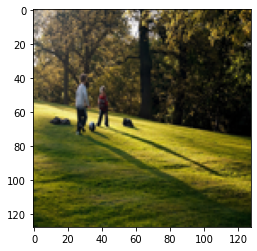

['two', 'boys', 'in', 'a', 'field', 'kicking', 'a', 'soccer', 'ball', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





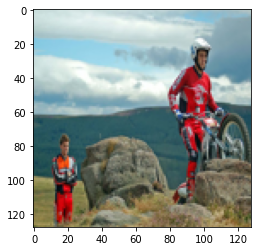

['a', 'dirt', 'biker', 'pushes', 'his', 'motorcycle', 'up', 'a', 'rock', 'while', 'another', 'rider', 'watches', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_', '_']





In [0]:
def show_random_image_and_captions(images, labels, idx_to_word):
  n = images.shape[0]
  idx = np.random.randint(0, n)

  plt.imshow(images[idx % images.shape[0], ...])
  plt.show()

  encoded_caption = labels[idx, ...]
  encoded_caption = [k for k in encoded_caption if k >= 0]
  caption = [idx_to_word[i] for i in encoded_caption]
  print(caption)
  print('\n\n')

show_random_image_and_captions(train_images, train_y, idx_to_word)
show_random_image_and_captions(val_images, val_y, idx_to_word)

# Make Model

The model takes two inputs:

*   *image_input*: placeholder for image codes.
*   *caption_inputs*: placeholder for integer-encoded captions. 

You need to insert the following structure:

*   Image embedding: *Dense* layer, mapping image codes to embeddings of length *embedding_dim*.
*   Caption embedding: *Embedding* layer, mapping integers to embeddings of length *embedding_dim*.
*   Concatenate Image embedding and Caption embeddings along the time axis. The image embedding should be at time t=0.
*   LSTM with *lstm_dim* units, taking the concatenated embedding as input.
*   Apply Dropout with rate 0.5 to the LSTM.
*   Output layer: *Dense* layer, mapping the output of the LSTM to a categorical distribution (via *softmax*) of length *num_words*.

**Hint:** The function K.expand_dims() might be useful here.



In [0]:
# ...
def make_model(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout):

  # inputs
  image_input = Input(shape=(code_length,))
  caption_input = Input(shape=(max_caption_length - 1,))

  # Make the Model, using Model(inputs=[image_input, caption_input], outputs=...)
  # Fill in the intermediate structure

  # ...

  # define layers
  image_embedding_layer = Dense(embedding_dim)
  caption_embedding_layer = Embedding(num_words, embedding_dim)
  lstm_layer = LSTM(lstm_dim, return_sequences=True, dropout=lstm_dropout)
  output_layer = Dense(num_words, activation='softmax')

  # make model
  image_embedding = image_embedding_layer(image_input)
  image_embedding_expand = K.expand_dims(image_embedding, axis=1)
  caption_embedding = caption_embedding_layer(caption_input)
  embedding = concatenate([image_embedding_expand, caption_embedding], 1)
  lstm_output = lstm_layer(embedding)
  output = output_layer(lstm_output)

  return Model([image_input, caption_input], output)

  # ...

model = make_model(code_length=train_codes.shape[1], 
                   max_caption_length=max_caption_length, 
                   embedding_dim=embedding_dim, 
                   num_words=num_words, 
                   lstm_dim=lstm_dim, 
                   lstm_dropout=lstm_dropout)

# Train Model

* Use Adam with learning rate 0.001 and early stopping with patience 1. 
Provide the separate validation set for early stopping.
* Use a batch size of 100.
* Use a maximal number of epochs of 100 (early stopping will likely stop training much earlier).
* Use crossentropy as loss function.
* Report which data serves as input and which serves as output, and why.
* **Hint:** Use the sparse version of crossentropy, in order to avoid memory issues.

In [0]:
early_stopping_callback = EarlyStopping(monitor='val_loss',
                                        min_delta=0,
                                        patience=1,
                                        verbose=1, 
                                        mode='auto')

# Train model using Adam, using (sparse) crossentropy
# Perform erly stopping using the separate validation set
# ...

adam = optimizers.Adam(learning_rate=0.001)
model.compile(loss=losses.sparse_categorical_crossentropy, optimizer=adam)

train_y_input = train_y[:, 0:-1]
val_y_input = val_y[:, 0:-1]

model.fit(x=[train_codes, train_y_input], 
          y=train_y, 
          validation_data=([val_codes, val_y_input], val_y), 
          batch_size=batch_size, 
          epochs=100, 
          callbacks=[early_stopping_callback],
          verbose=1)

# ...

model.save(os.path.join(base_path, 'model.h5'))

Epoch 1/100
305/305 [==============================] - 18s 60ms/step - loss: 1.6486 - val_loss: 1.3375
Epoch 2/100
305/305 [==============================] - 18s 58ms/step - loss: 1.2561 - val_loss: 1.1953
Epoch 3/100
305/305 [==============================] - 18s 58ms/step - loss: 1.1435 - val_loss: 1.1248
Epoch 4/100
305/305 [==============================] - 18s 59ms/step - loss: 1.0751 - val_loss: 1.0752
Epoch 5/100
305/305 [==============================] - 18s 59ms/step - loss: 1.0234 - val_loss: 1.0422
Epoch 6/100
305/305 [==============================] - 18s 59ms/step - loss: 0.9834 - val_loss: 1.0172
Epoch 7/100
305/305 [==============================] - 18s 59ms/step - loss: 0.9512 - val_loss: 1.0006
Epoch 8/100
305/305 [==============================] - 18s 59ms/step - loss: 0.9239 - val_loss: 0.9866
Epoch 9/100
305/305 [==============================] - 18s 59ms/step - loss: 0.9010 - val_loss: 0.9776
Epoch 10/100
305/305 [==============================] - 18s 59ms/step - l

# Evaluate Model

* Evaluate and report the final train and validation loss.

In [0]:
model = load_model(os.path.join(base_path, 'model.h5'))
model.summary()

# ...

train_y_input = train_y[:, 0:-1]
val_y_input = val_y[:, 0:-1]

model.evaluate(x=[train_codes, train_y_input], y=train_y, batch_size=250)
model.evaluate(x=[val_codes, val_y_input], y=val_y, batch_size=250)

# ...

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 20480)]      0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 512)          10486272    input_2[0][0]                    
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 34)]         0                                            
__________________________________________________________________________________________________
tf_op_layer_ExpandDims (TensorF (None, 1, 512)       0           dense[0][0]                      
______________________________________________________________________________________________

0.9588349461555481

# Make Decoder

* Make a greedy decoder model, which iteratively predicts the most likely word at each time step. The decoder is akin to the trained model above, but with a crucial difference: at time step t (t > 0), the LSTM takes the embedding of the word *predicted at time step t-1* as input. At time t=0, the LSTM takes the image embedding as input.
* The decoder should return the predicted captions, encoded as integer matrix of shape (batch_size, max_caption_length).
* Equip the decoder with the weights of the trained model. 
* **Hint:** You will need to pass on the internal state of the LSTM from time step to time step. To this end, use the argument *return_state=True* when creating the LSTM, and the *initial_state* argument when calling the LSTM. 
* **Hint:** Use the argument *weights* to pass the parameters of the trained model. This should contain the weights for image embedding, word embedding, LSTM, and output layer. Use the methods *get_weights()* and *set_weights()* to this end.
* **Hint:** The functions *K.expand_dims()*, *K.argmax()*, and *K.stack()* might be useful here.

In [0]:
def make_decoder(code_length, max_caption_length, embedding_dim, num_words, lstm_dim, lstm_dropout, weights):
  image_input = Input(shape=(code_length,))
  
  # ...

  image_embedding_layer = Dense(embedding_dim)
  caption_embedding_layer = Embedding(num_words, embedding_dim)
  lstm_layer = LSTM(lstm_dim, return_state=True, dropout=lstm_dropout)
  output_layer = Dense(num_words, activation='softmax')

  decoded = []

  image_embedding = image_embedding_layer(image_input)
  image_embedding_expand = K.expand_dims(image_embedding, axis=1)
  lstm_out, h_state, c_state = lstm_layer(image_embedding_expand)
  output = output_layer(lstm_out)
  cur_decoded = K.argmax(output, 1)
  decoded.append(cur_decoded)

  for k in range(1, max_caption_length):
    caption_embedding = caption_embedding_layer(cur_decoded)
    caption_embedding_expand = K.expand_dims(caption_embedding, axis=1)
    lstm_out, h_state, c_state = lstm_layer(caption_embedding_expand, 
                                            initial_state=[h_state, c_state])
    output = output_layer(lstm_out)
    cur_decoded = K.argmax(output, 1)
    decoded.append(cur_decoded)

  model = Model(image_input, K.stack(decoded, 1))
  
  image_embedding_layer.set_weights(weights[0])
  caption_embedding_layer.set_weights(weights[1])
  lstm_layer.set_weights(weights[2])
  output_layer.set_weights(weights[3])

  # ...

  return model

# Get the weights from model, and put them in a list 'weights'.
# ...

weights = [model.get_layer('dense').get_weights(),
           model.get_layer('embedding').get_weights(),
           model.get_layer('lstm').get_weights(),
           model.get_layer('dense_1').get_weights()]

# ...

decoder = make_decoder(code_length=train_codes.shape[1], 
                       max_caption_length=max_caption_length,
                       embedding_dim=embedding_dim,
                       num_words=num_words, 
                       lstm_dim=lstm_dim, 
                       lstm_dropout=lstm_dropout,
                       weights=weights)

# Predict Test Captions

*   Use the decoder to predict the test captions.
*   Decode them to text using the mapping *idx_to_word*.
*   Show 10 random test images and their predicted captions. Categorize them like in Figure 5 in the paper.
*   Report the 1-gram, 2-gram, 3-gram, and 4-gram BLEU scores of the test predictions. **Hint:** You can use the *nltk* package for this. 


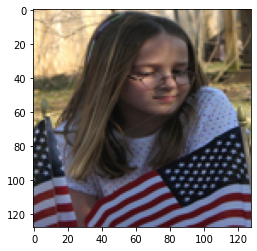

['a', 'girl', 'in', 'a', 'pink', 'shirt', 'is', 'blowing', 'bubbles']





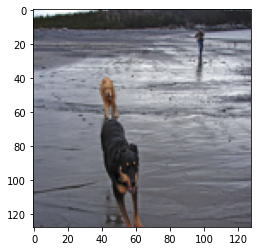

['a', 'dog', 'running', 'through', 'the', 'water']





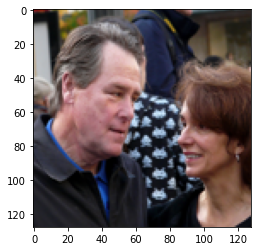

['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'a', 'woman', 'in', 'a', 'black', 'shirt', 'and', 'a', 'woman', 'in', 'a', 'black', 'shirt']





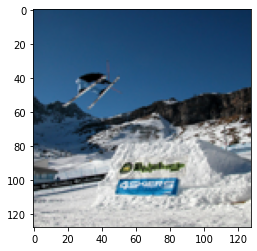

['a', 'snowboarder', 'is', 'jumping', 'over', 'a', 'jump']





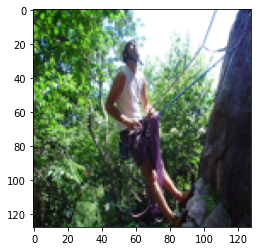

['a', 'man', 'in', 'a', 'blue', 'shirt', 'climbs', 'a', 'rock', 'face']





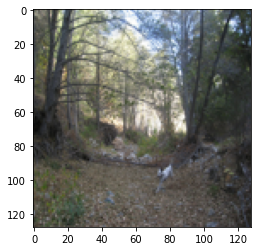

['a', 'dog', 'is', 'running', 'through', 'the', 'woods']





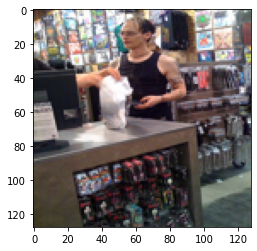

['a', 'man', 'in', 'a', 'black', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd', 'of', 'people']





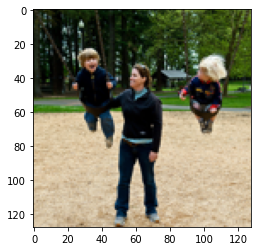

['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'a', 'woman', 'in', 'a', 'black', 'shirt', 'and', 'a', 'white', 'shirt', 'are', 'playing', 'in', 'a', 'field']





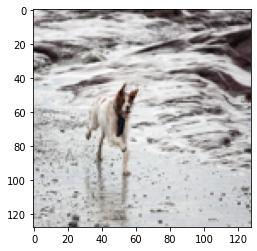

['a', 'dog', 'is', 'running', 'through', 'the', 'water']





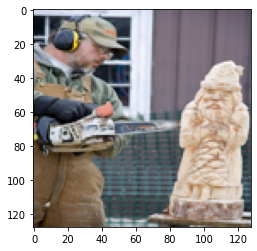

['a', 'man', 'in', 'a', 'blue', 'shirt', 'is', 'standing', 'on', 'a', 'rock']



BLEU-1: 0.5138034112889045
BLEU-2: 0.21669558511663775
BLEU-3: 0.08406229997866438
BLEU-4: 0.03391449725340339


In [0]:
predictions = None
for k in range(10):
  test_batch = test_codes[(k*100):((k+1)*100), ...]
  predictions_batch = decoder(test_batch)
  if predictions is None:
    predictions = predictions_batch
  else:
    predictions = np.concatenate((predictions, predictions_batch), 0)

predicted_captions = []
for k in range(predictions.shape[0]):
  encoded_caption = [i for i in predictions[k, ...] if i != word_to_idx['_']]
  predicted_captions.append([idx_to_word[i] for i in encoded_caption])

rp = np.random.permutation(test_images.shape[0])

for k in rp[0:10]:
  plt.imshow(test_images[k, ...])
  plt.show()
  print(predicted_captions[k])
  print('\n\n')

bleu1 = nltk.translate.bleu_score.corpus_bleu(test_captions, predicted_captions, weights=(1., 0., 0., 0.))
bleu2 = nltk.translate.bleu_score.corpus_bleu(test_captions, predicted_captions, weights=(0., 1., 0., 0.))
bleu3 = nltk.translate.bleu_score.corpus_bleu(test_captions, predicted_captions, weights=(0., 0., 1., 0.))
bleu4 = nltk.translate.bleu_score.corpus_bleu(test_captions, predicted_captions, weights=(0., 0., 0., 1.))
print("BLEU-1: {}".format(bleu1))
print("BLEU-2: {}".format(bleu2))
print("BLEU-3: {}".format(bleu3))
print("BLEU-4: {}".format(bleu4))

# Study BLEU

/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 2-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 3-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)
/usr/local/lib/python3.6/dist-packages/nltk/translate/bleu_score.py:490: UserWarning: 
Corpus/Sentence contains 0 counts of 4-gram overlaps.
BLEU scores might be undesirable; use SmoothingFunction().
  warnings.warn(_msg)


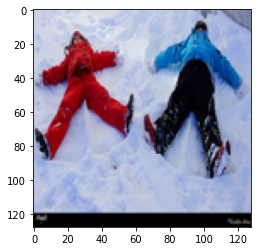

[['the', 'children', 'make', 'snow', 'angels', 'next', 'to', 'each', 'other'], ['two', 'children', 'are', 'making', 'snow', 'angels'], ['two', 'children', 'lying', 'in', 'the', 'snow', 'making', 'snow', 'angels'], ['two', 'children', 'one', 'in', 'red', 'and', 'one', 'in', 'blue', 'making', 'snow', 'angels'], ['two', 'people', 'in', 'laying', 'in', 'the', 'snow', 'making', 'snow', 'angels']]
['a', 'man', 'is', 'skiing', 'down', 'a', 'snowy', 'hill']
0.0


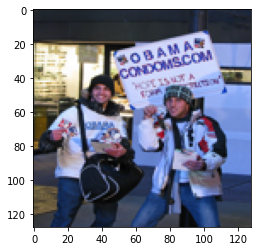

[['the', 'two', 'guys', 'in', 'blue', 'jeans', 'and', 'winter', 'hats', 'hand', 'out'], ['two', 'men', 'sell', 'like', 'with', 'obama', 'on', 'them'], ['two', 'young', 'men', 'obama'], ['two', 'young', 'men', 'their', 'wearing', 'knit', 'caps', 'and', 'trying', 'to', 'sell'], ['two', 'young', 'men', 'stand', 'in', 'front', 'of', 'a', 'sign', 'advertising', 'a']]
['a', 'man', 'in', 'a', 'red', 'shirt', 'is', 'standing', 'in', 'front', 'of', 'a', 'crowd']
0.38461538461538464


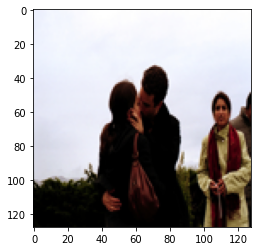

[['a', 'couple', 'kiss', 'outdoors', 'while', 'another', 'couple', 'watch'], ['a', 'man', 'and', 'a', 'woman', 'are', 'outside', 'kissing', 'with', 'a', 'woman', 'wearing', 'a', 'red', 'scarf', 'in', 'the', 'background'], ['the', 'woman', 'on', 'the', 'right', 'is', 'wearing', 'a', 'red', 'scarf'], ['two', 'people', 'in', 'complete', 'love', 'are', 'kissing', 'in', 'the', 'beautiful', 'embrace'], ['two', 'people', 'kissing']]
['a', 'man', 'in', 'a', 'black', 'shirt', 'and', 'a', 'woman', 'in', 'a', 'black', 'shirt', 'and', 'a', 'woman', 'in', 'a', 'black', 'shirt']
0.5


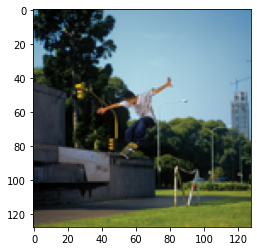

[['a', 'boy', 'in', 'a', 'white', 't-shirt', 'does', 'skateboard', 'tricks'], ['a', 'boy', 'in', 't-shirt', 'jeans', 'and', 'knit', 'cap', 'jumps', 'up', 'with', 'his', 'skating', 'board', 'arms', 'out'], ['a', 'man', 'performs', 'a', 'skateboarding', 'trick', 'on', 'a', 'cement', 'monument', 'in', 'a', 'city', 'park'], ['a', 'skateboarder', 'is', 'airborne', 'in', 'a', 'city', 'green', 'space'], ['young', 'skateboarder', 'doing', 'a', 'trick', 'in', 'the', 'park']]
['a', 'man', 'in', 'a', 'black', 'shirt', 'is', 'jumping', 'off', 'a', 'skateboard']
0.6363636363636364


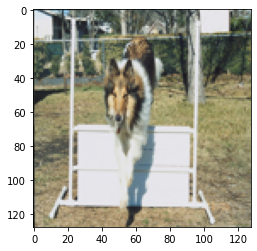

[['a', 'border', 'collie', 'is', 'outside', 'jumping', 'over', 'an', 'obstacle'], ['a', 'collie', 'jumping', 'over', 'a', 'white', 'obstacle'], ['a', 'collie', 'jumps', 'a', 'hurdle'], ['a', 'collie', 'jumps', 'over', 'a', 'white', 'agility', 'jump'], ['a', 'dog', 'jumps', 'over', 'a', 'hurdle', 'in', 'the', 'grass']]
['a', 'dog', 'is', 'jumping', 'over', 'a', 'hurdle']
1.0


In [0]:
sentence_bleus = []
for k in range(len(test_captions)):
  bleu = nltk.translate.bleu_score.sentence_bleu(test_captions[k], 
                                                 predicted_captions[k], 
                                                 weights=(1., 0., 0., 0.))
  sentence_bleus.append(bleu)

sentence_bleus = np.array(sentence_bleus)
sorted_idx = np.argsort(sentence_bleus)
# print(sentence_bleus[sorted_idx])

for k in [0, 250, 500, 750, 999]:
  plt.imshow(test_images[sorted_idx[k]])
  plt.show()
  print(test_captions[sorted_idx[k]])
  print(predicted_captions[sorted_idx[k]])
  print(sentence_bleus[sorted_idx[k]])

